In [91]:
import itertools
import os
import warnings
import pandas as pd
import sklearn
import statsmodels.api as sm
import tslearn.clustering

%pylab inline
pylab.rcParams['figure.figsize'] = (36, 6)

Populating the interactive namespace from numpy and matplotlib


Создадим датафрейм, объединяющий данные о поездках за 5 месяцев (декабрь 2015 - апрель 2016) из данных, подготовленных на 3-й неделе и выделим из них те регионы, из которых в среднем в мае 2016 совершалось больше 5 поездок в час (как в задании на второй неделе).

In [2]:
names = ["yellow_tripdata_%s.pickle" % month for month in ["2015-12", "2016-01", "2016-02", "2016-03", "2016-04"]]
data = pd.read_pickle("../" + names[0])
for name in names[1:]:
    data = pd.concat([data, pd.read_pickle("../" + name)])
    
may2016 = pd.read_pickle('../yellow_tripdata_2016-05.pickle')
avg = may2016.mean(axis=0) >= 5
data = data[avg.index[avg]]

data.shape

(3648, 102)

In [3]:
data.head(2)

1075  1076  1077  1125  1126  1127  1128  1129  1130  \
2015-12-01 00:00:00    19    43    26    76    91   129   202   230   212   
2015-12-01 01:00:00    16    22    12    29    71    84    89   118   177   

                     1131  ...   1630  1684  1733  1734  1783  2068  2069  \
2015-12-01 00:00:00    56  ...      3     0     2    97    29    96    16   
2015-12-01 01:00:00    18  ...      7     0     0     2     0    17     4   

                     2118  2119  2168  
2015-12-01 00:00:00   246    31   118  
2015-12-01 01:00:00   104     5    75  

[2 rows x 102 columns]

In [4]:
data.tail(2)

1075  1076  1077  1125  1126  1127  1128  1129  1130  \
2016-04-30 22:00:00   100    97    85   100   217   421   697   955   909   
2016-04-30 23:00:00    92   118    63    86   284   529   733   838   918   

                     1131  ...   1630  1684  1733  1734  1783  2068  2069  \
2016-04-30 22:00:00   203  ...      1     0     2   230    80   132    21   
2016-04-30 23:00:00   185  ...      4     0     0   195    54   134    10   

                     2118  2119  2168  
2016-04-30 22:00:00   198    23    93  
2016-04-30 23:00:00   181    74    39  

[2 rows x 102 columns]

Нормализуем столбцы.

In [5]:
data_norm = ((data - data.mean()) / data.std()).fillna(0)

Разобьем наши данные о поездках на 5 кластеров.

In [10]:
data_ts = data_norm.as_matrix().T.reshape((data_norm.shape[1], data_norm.shape[0], 1))
model = tslearn.clustering.TimeSeriesKMeans(n_clusters=5, metric='dtw')
ts_ks = model.fit_predict(data_ts)

726.491 --> 474.816 --> 471.936 --> 471.936 --> 


In [34]:
clusters = pd.DataFrame(index=data_norm.columns, data={'cluster': ts_ks})
for i in range(0, 5):
    data_norm["c" + str(i)] = model.cluster_centers_[i].reshape(data_norm.shape[0]).T

Построим графики центров полученных кластеров и убедимся, что они визуально отличаются друг от друга.

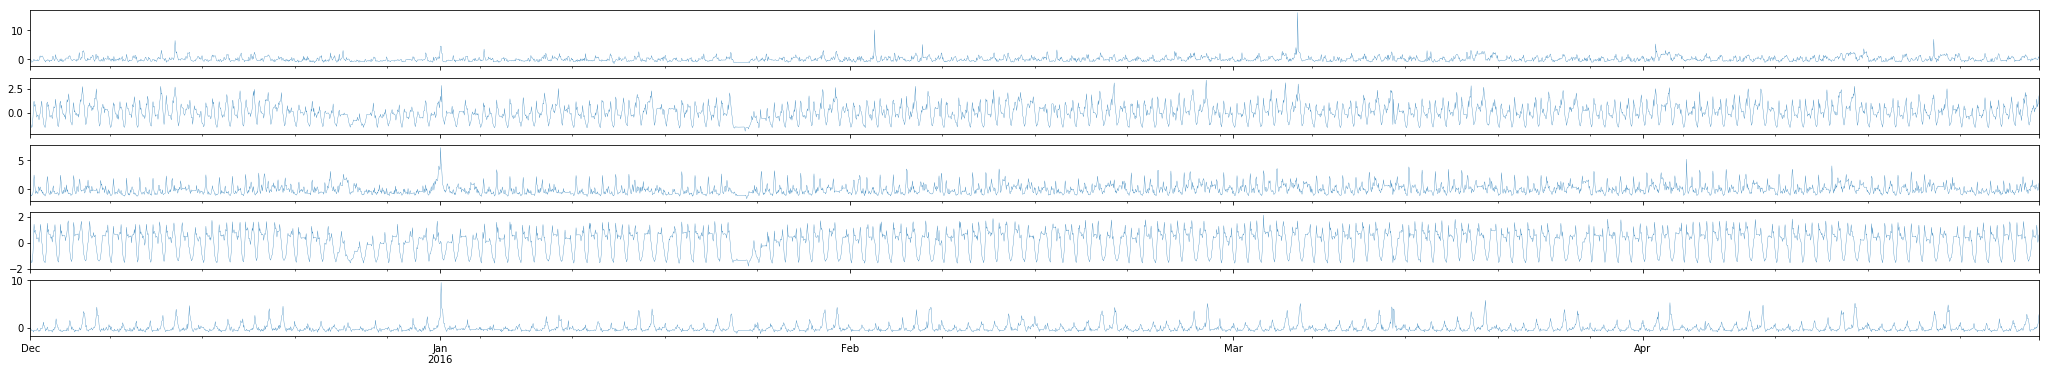

In [46]:
f, axarr = plt.subplots(5, sharex=True)
for i in range(0, 5):
    data_norm["c" + str(i)].plot(linewidth=0.3, ax=axarr[i])

Будем использовать полученные центры кластеров для настройки коэффициентов регрессии и ARIMA. Коэффициенты регрессии будем использовать одинаковые для всех кластеров, а параметры ARIMA подберем индивидуально по остаткам.

In [62]:
K = 50
ARIMA = {}
ex = pd.DataFrame(index=data_norm.index)
ex['lin'] = np.arange(data_norm.shape[0])
ex['const'] = 1.0
for i in range(0, K):
    ex["s%d"%i] = np.sin(np.arange(data.shape[0]) * 2.0 * np.pi * i / 168)
    ex["c%d"%i] = np.cos(np.arange(data.shape[0]) * 2.0 * np.pi * i / 168)

Для кластера №0

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


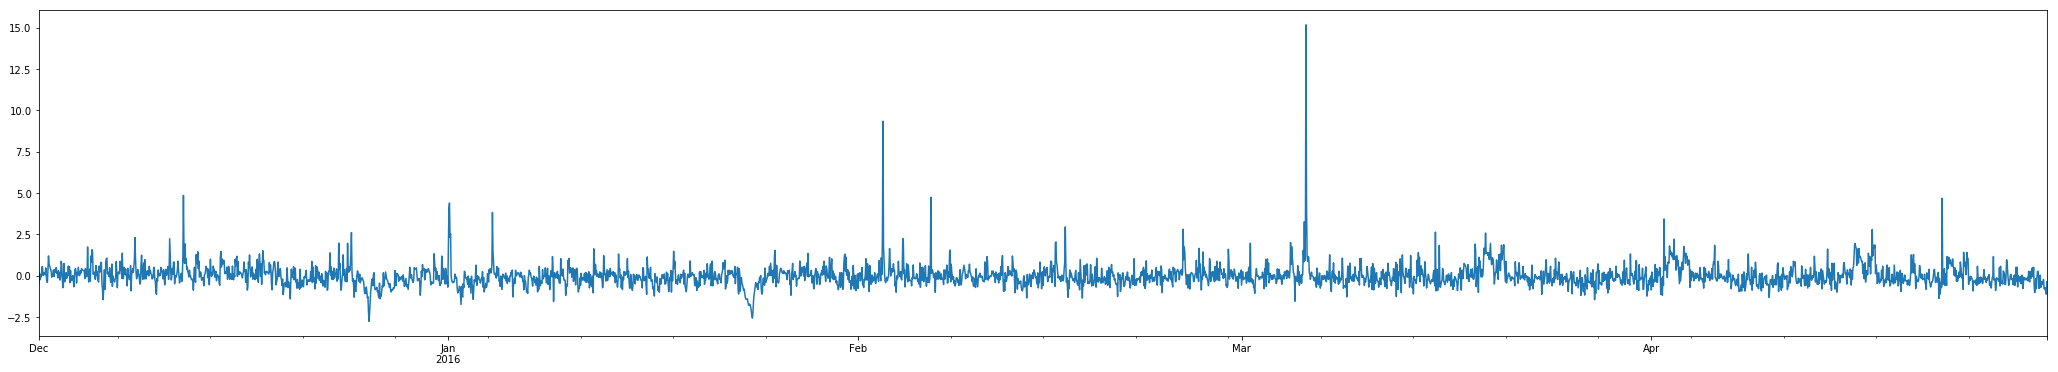

In [50]:
lrm = sklearn.linear_model.LinearRegression()
lrm.fit(ex, data_norm.c0)
data_norm.c0_residuals = data_norm.c0 - lrm.predict(ex)
data_norm.c0_residuals.plot()

Построим STL-декомпозицию полученного ряда.

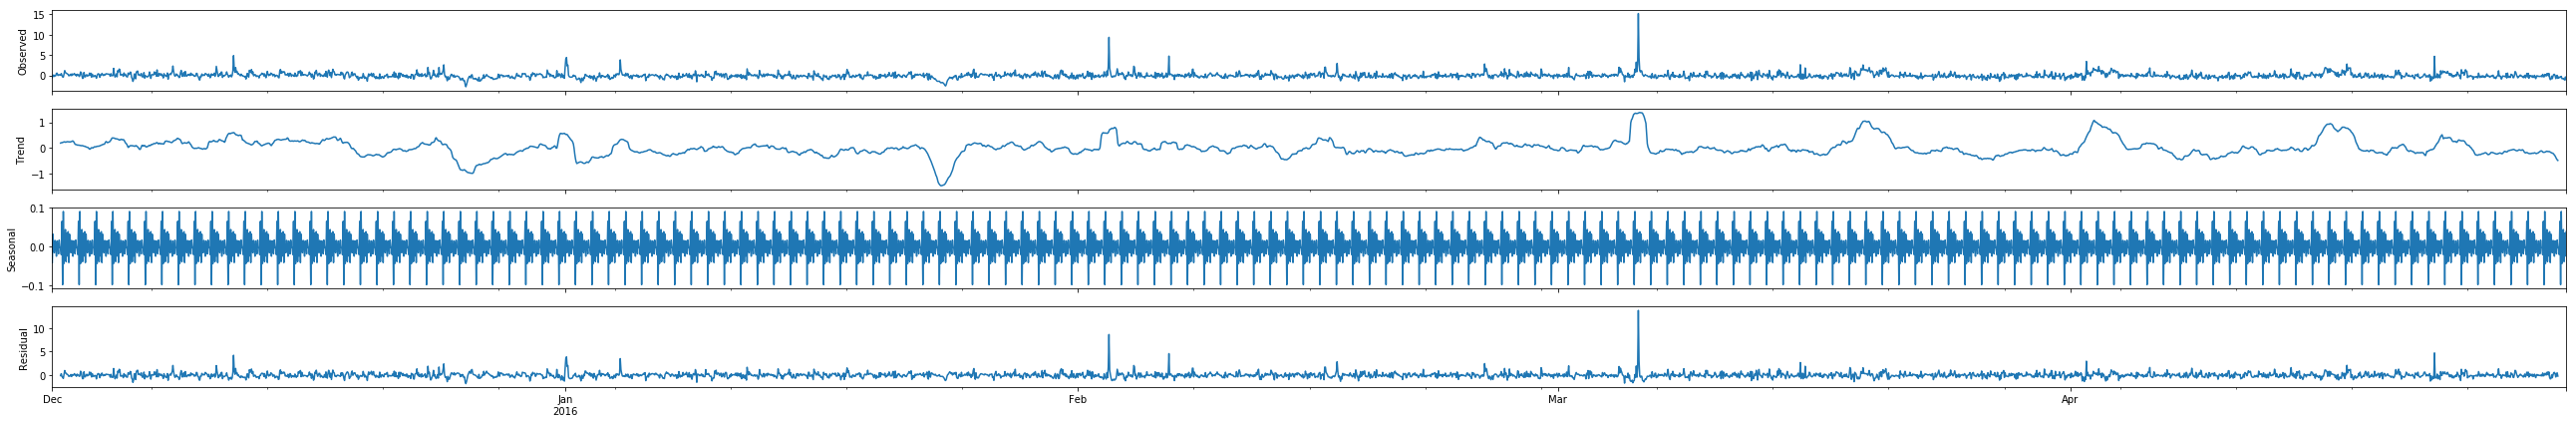

In [56]:
sm.tsa.seasonal_decompose(data_norm.c0_residuals).plot()
pass

Виден небольшой тренд. Проведем дифференцирование и построим STL декомпозицию еще раз.

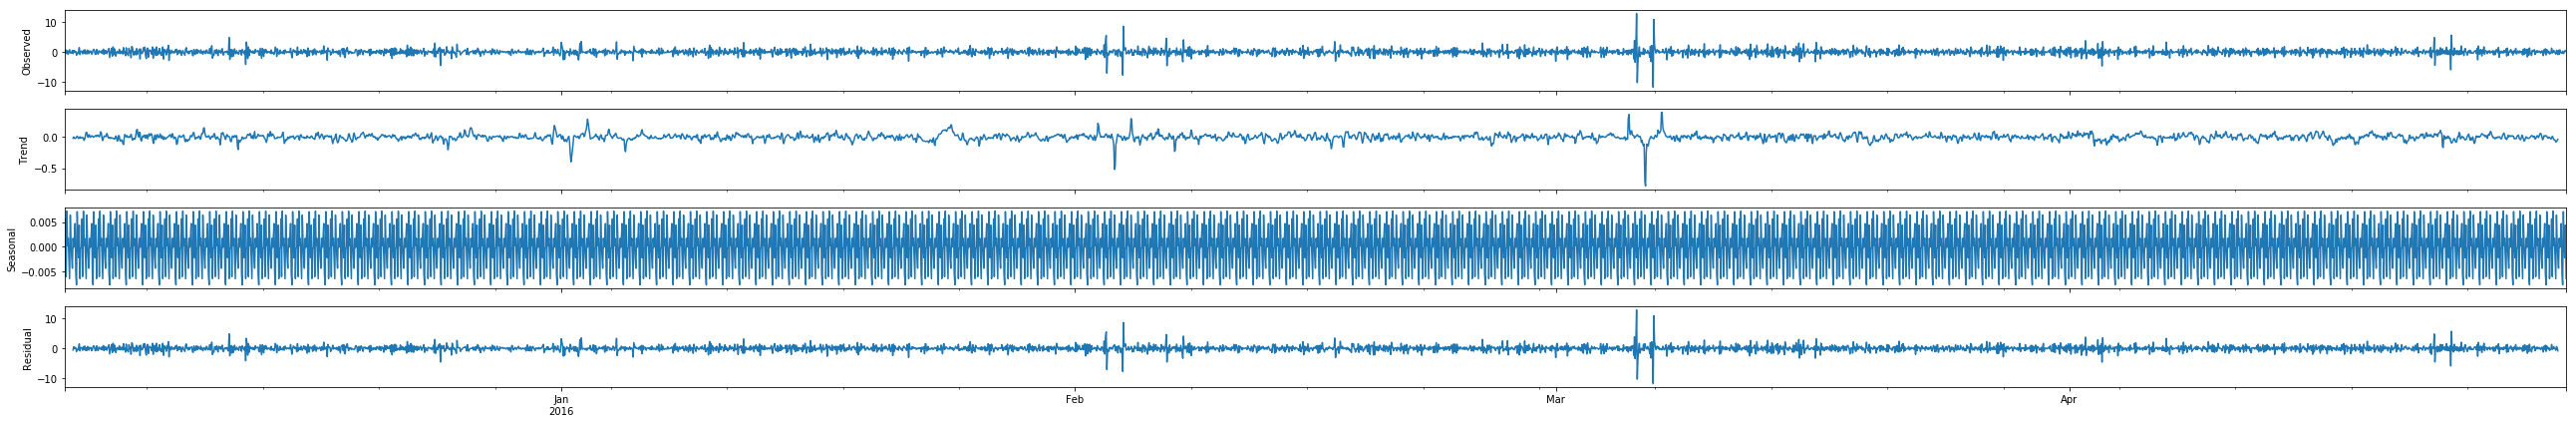

In [58]:
data_norm.c0_residuals_diff = data_norm.c0_residuals - data_norm.c0_residuals.shift(24)
data_norm.c0_residuals_diff2 = data_norm.c0_residuals_diff - data_norm.c0_residuals_diff.shift(1)
sm.tsa.seasonal_decompose(data_norm.c0_residuals_diff2[25:]).plot()
pass

Удалось избавится от тренда. Построим ACF и PACF остатков.

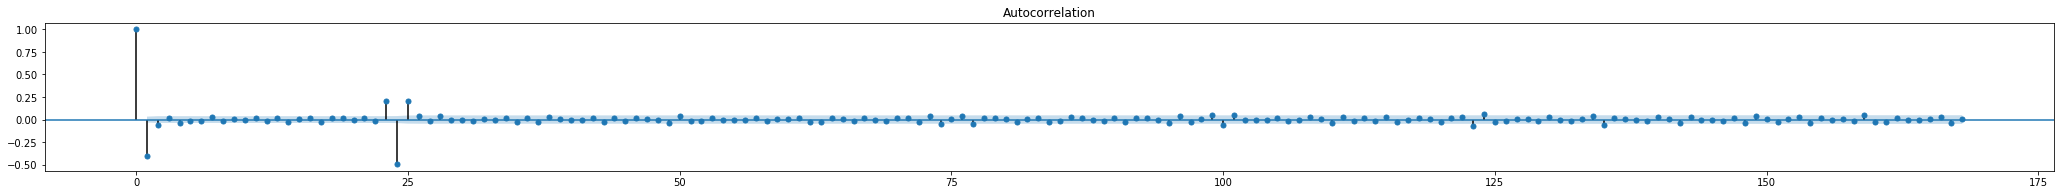

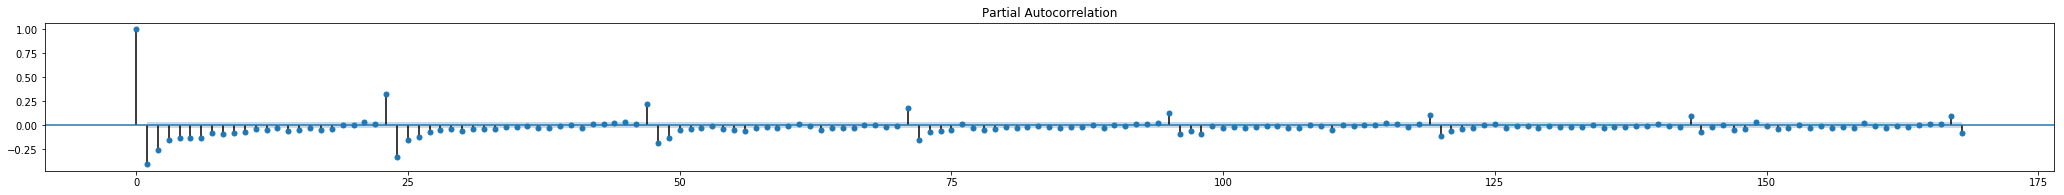

In [59]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_norm.c0_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_norm.c0_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

In [64]:
ARIMA['c0'] = {
    'Q': 1,
    'q': 1,
    'P': 2,
    'p': 2,
}

Для кластера №1

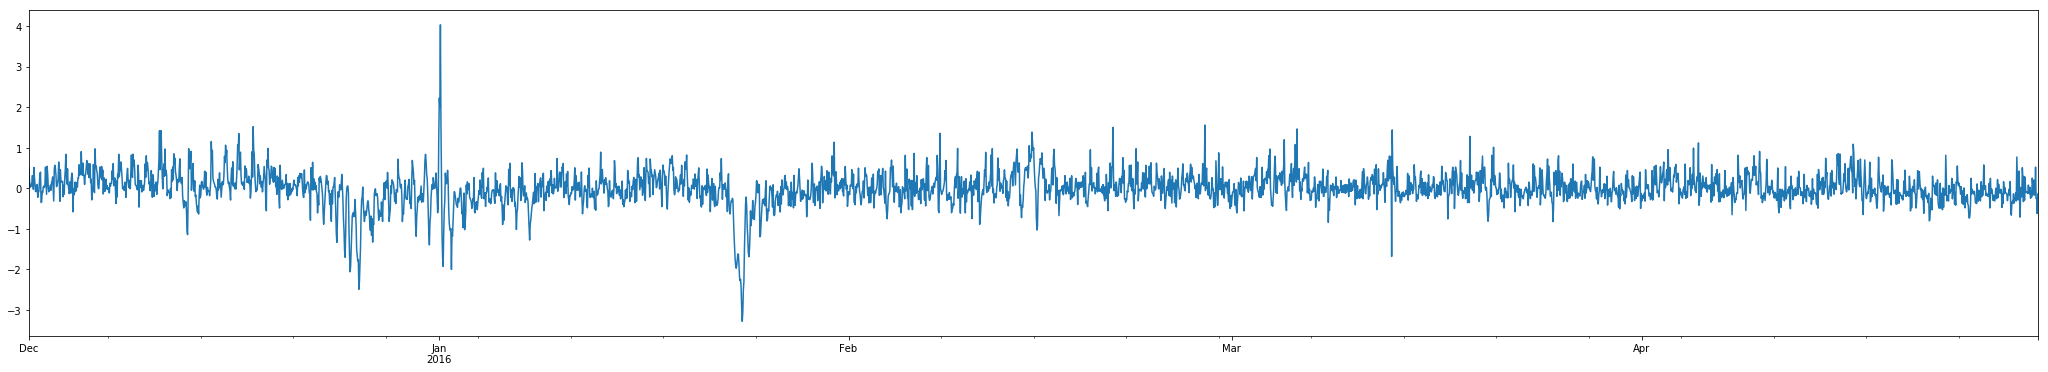

In [65]:
lrm = sklearn.linear_model.LinearRegression()
lrm.fit(ex, data_norm.c1)
data_norm.c1_residuals = data_norm.c1 - lrm.predict(ex)
data_norm.c1_residuals.plot()

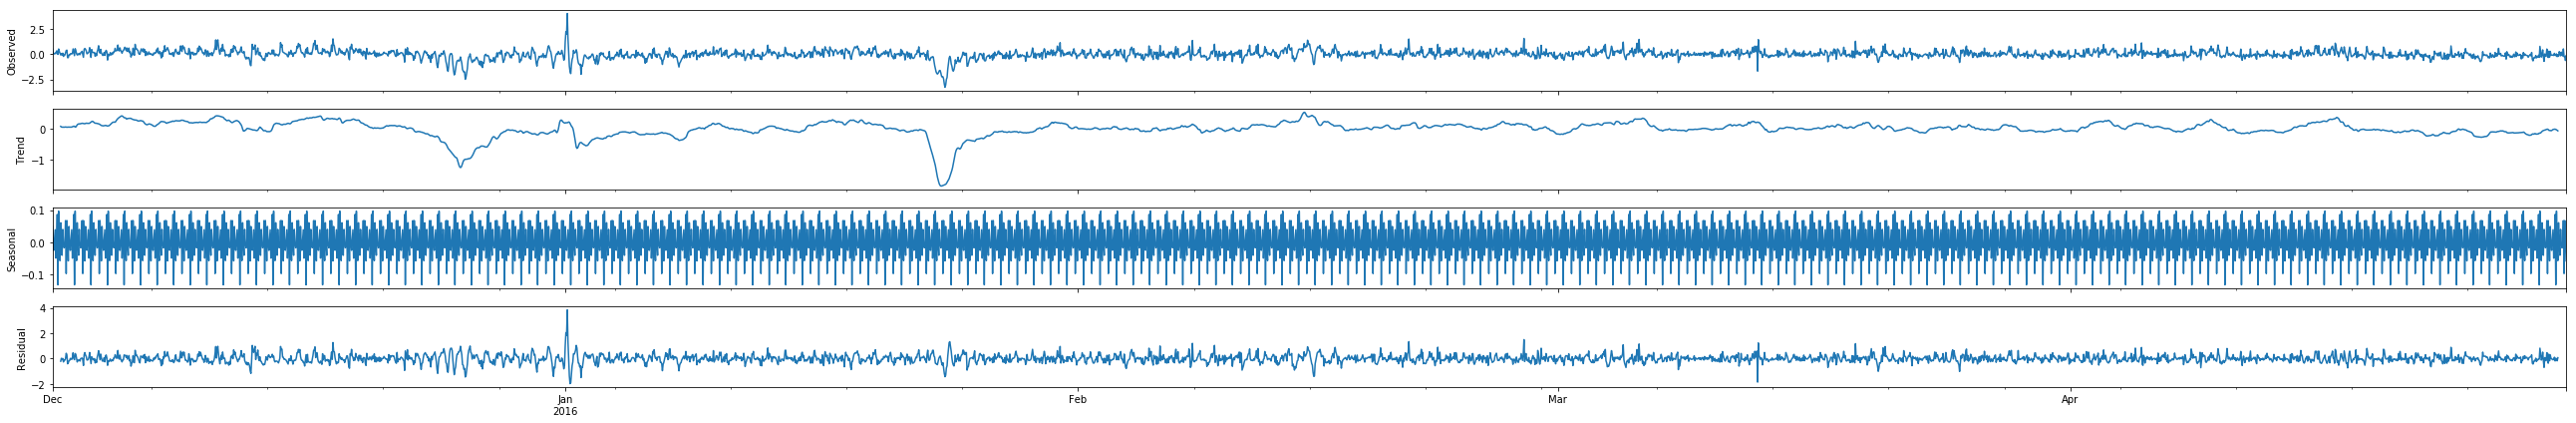

In [67]:
sm.tsa.seasonal_decompose(data_norm.c1_residuals).plot()
pass

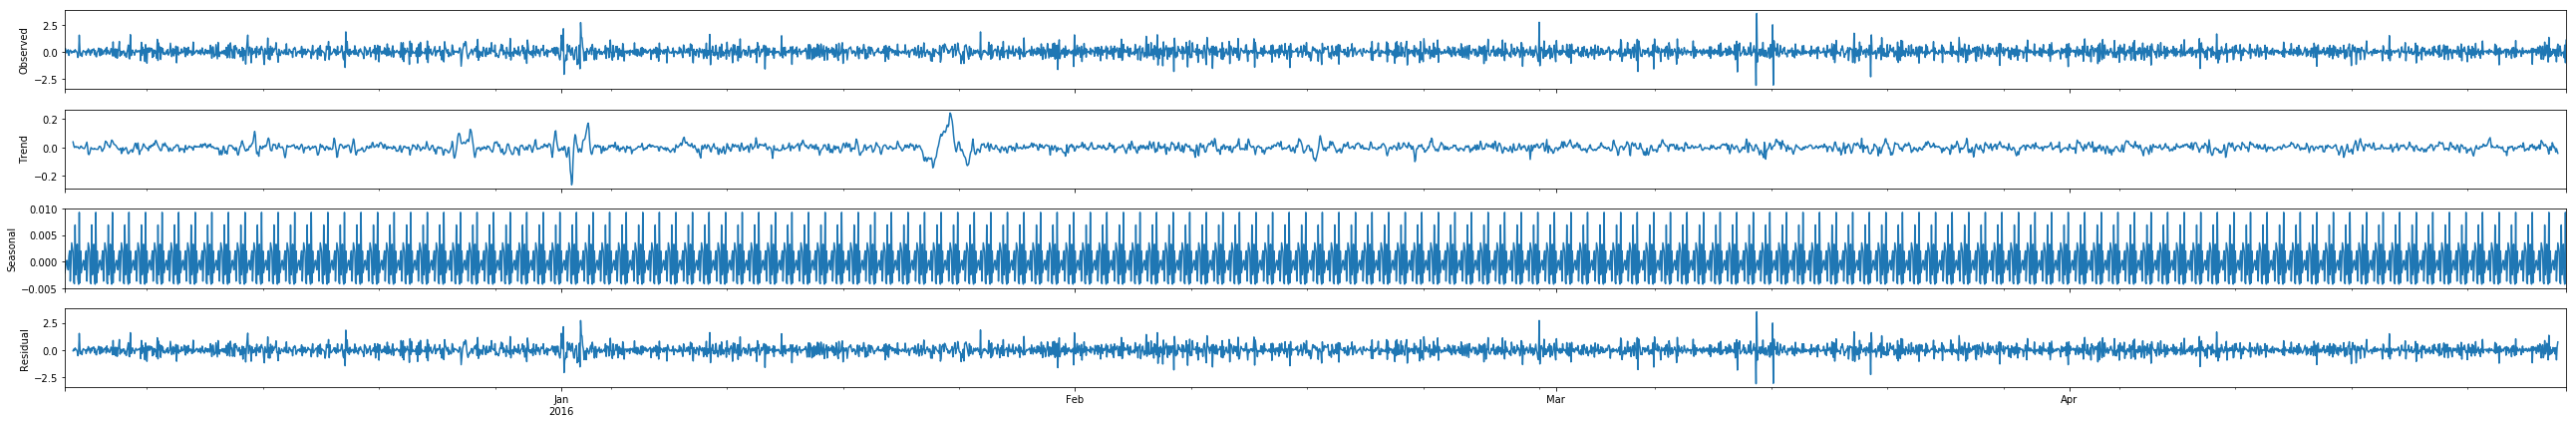

In [71]:
data_norm.c1_residuals_diff = data_norm.c1_residuals - data_norm.c1_residuals.shift(24)
data_norm.c1_residuals_diff2 = data_norm.c1_residuals_diff - data_norm.c1_residuals_diff.shift(1)
sm.tsa.seasonal_decompose(data_norm.c1_residuals_diff2[25:]).plot()
pass

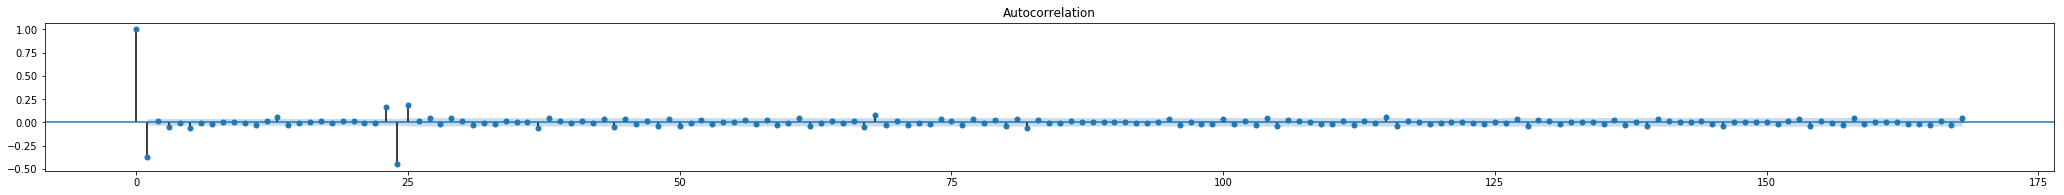

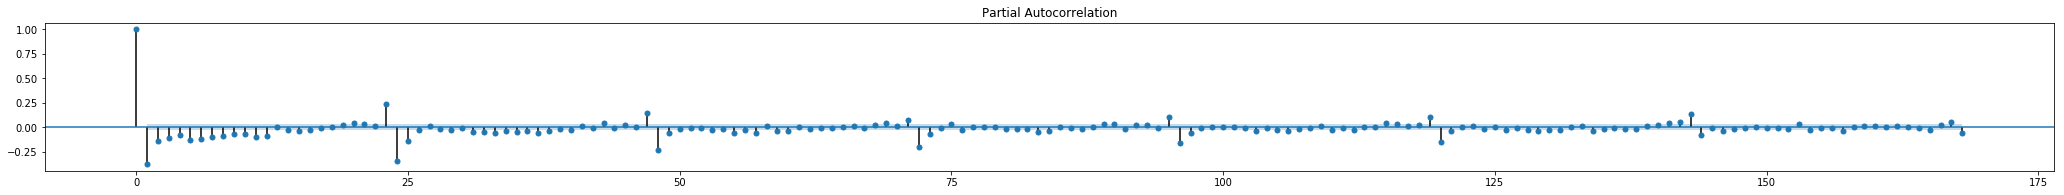

In [72]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_norm.c1_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_norm.c1_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

In [83]:
ARIMA['c1'] = {
    'Q': 1,
    'q': 1,
    'P': 2,
    'p': 5,
}

Для кластера №2

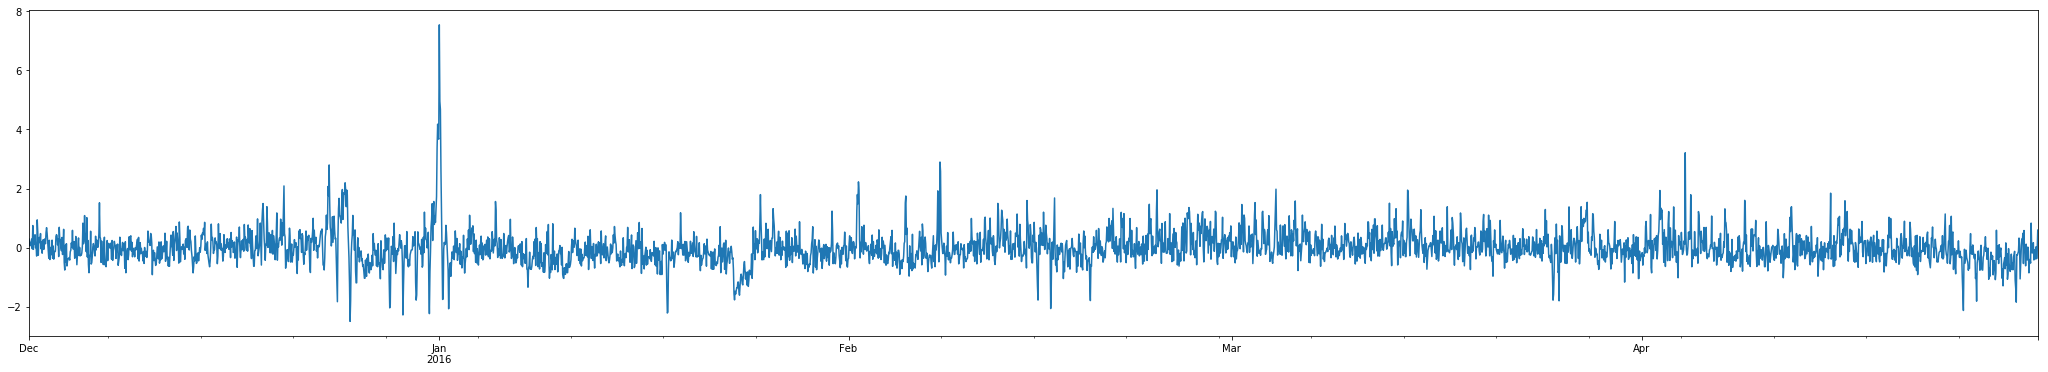

In [74]:
lrm = sklearn.linear_model.LinearRegression()
lrm.fit(ex, data_norm.c2)
data_norm.c2_residuals = data_norm.c2 - lrm.predict(ex)
data_norm.c2_residuals.plot()

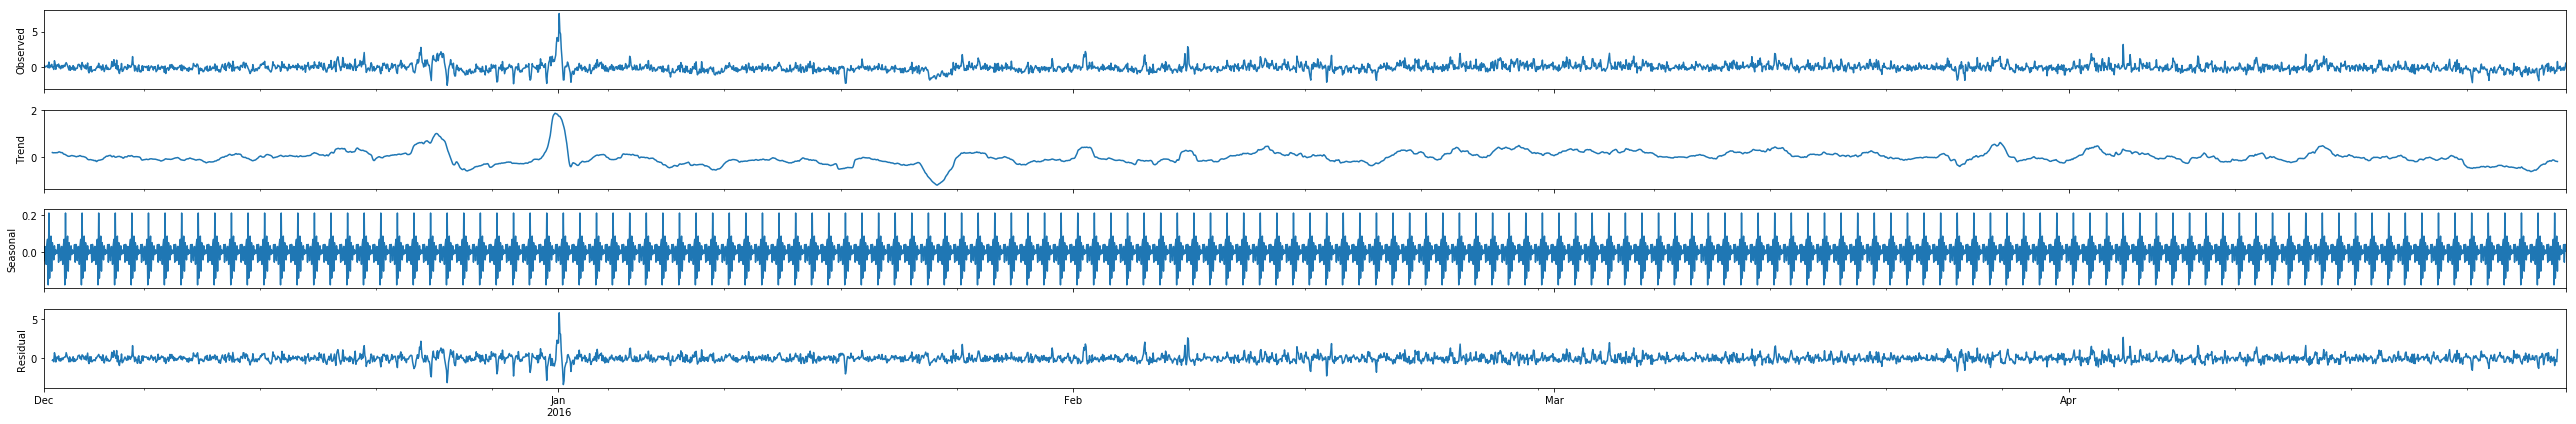

In [75]:
sm.tsa.seasonal_decompose(data_norm.c2_residuals).plot()
pass

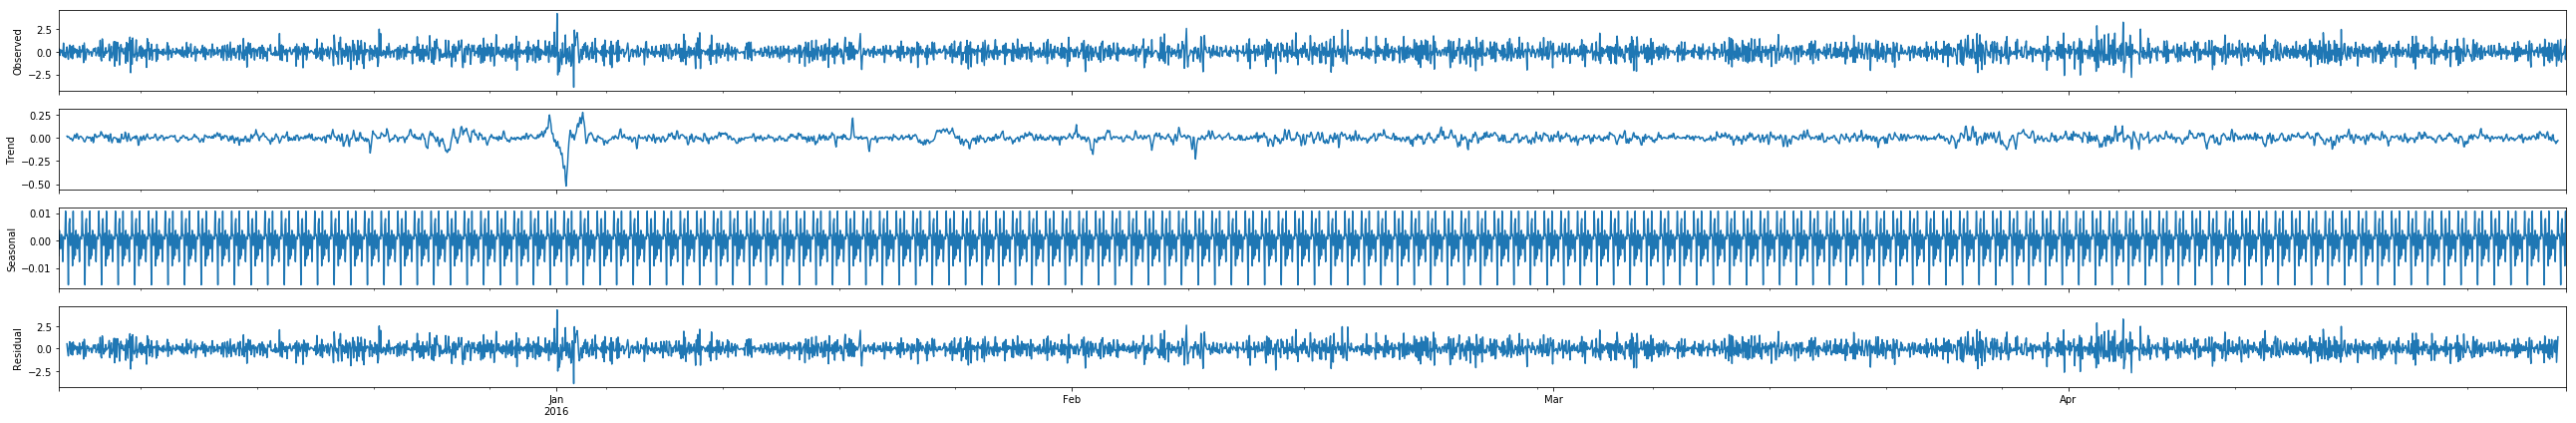

In [76]:
data_norm.c2_residuals_diff = data_norm.c2_residuals - data_norm.c2_residuals.shift(24)
data_norm.c2_residuals_diff2 = data_norm.c2_residuals_diff - data_norm.c2_residuals_diff.shift(1)
sm.tsa.seasonal_decompose(data_norm.c2_residuals_diff2[25:]).plot()
pass

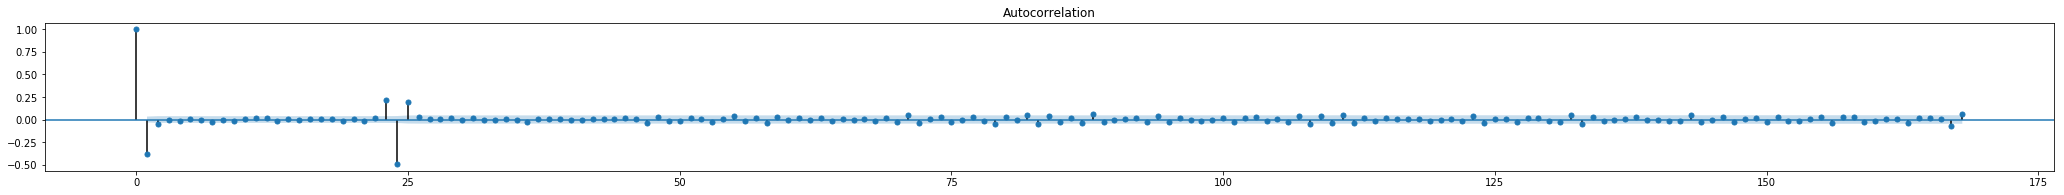

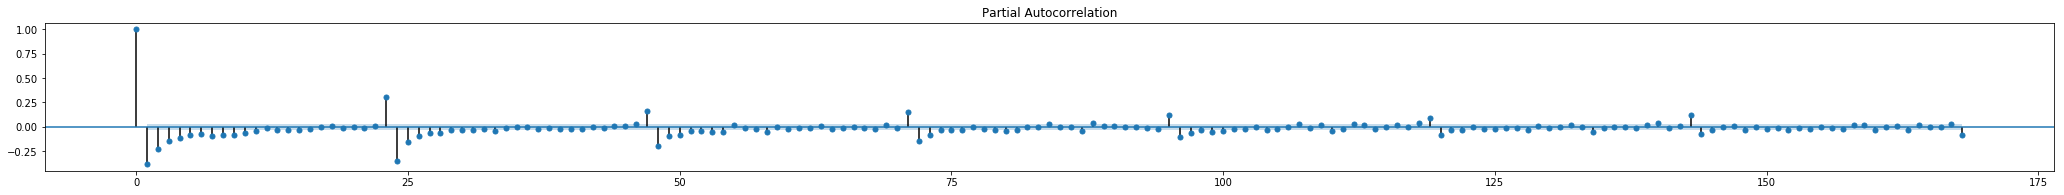

In [77]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_norm.c2_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_norm.c2_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

In [78]:
ARIMA['c2'] = {
    'Q': 1,
    'q': 1,
    'P': 2,
    'p': 2,
}

Для кластера №3

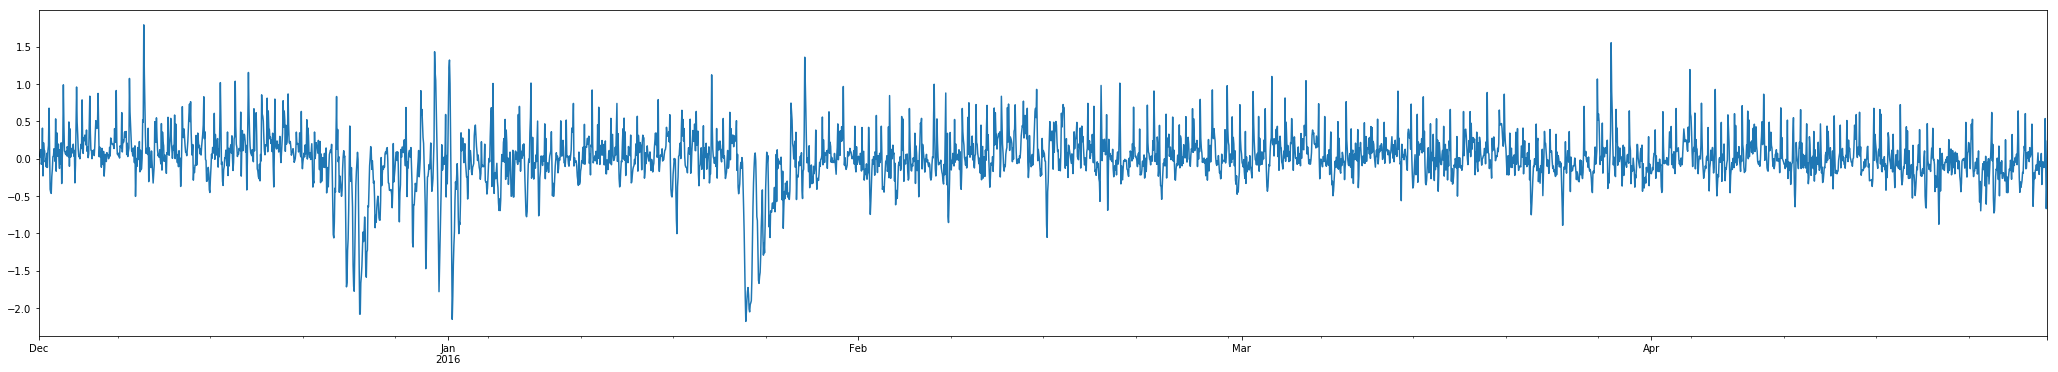

In [79]:
lrm = sklearn.linear_model.LinearRegression()
lrm.fit(ex, data_norm.c3)
data_norm.c3_residuals = data_norm.c3 - lrm.predict(ex)
data_norm.c3_residuals.plot()

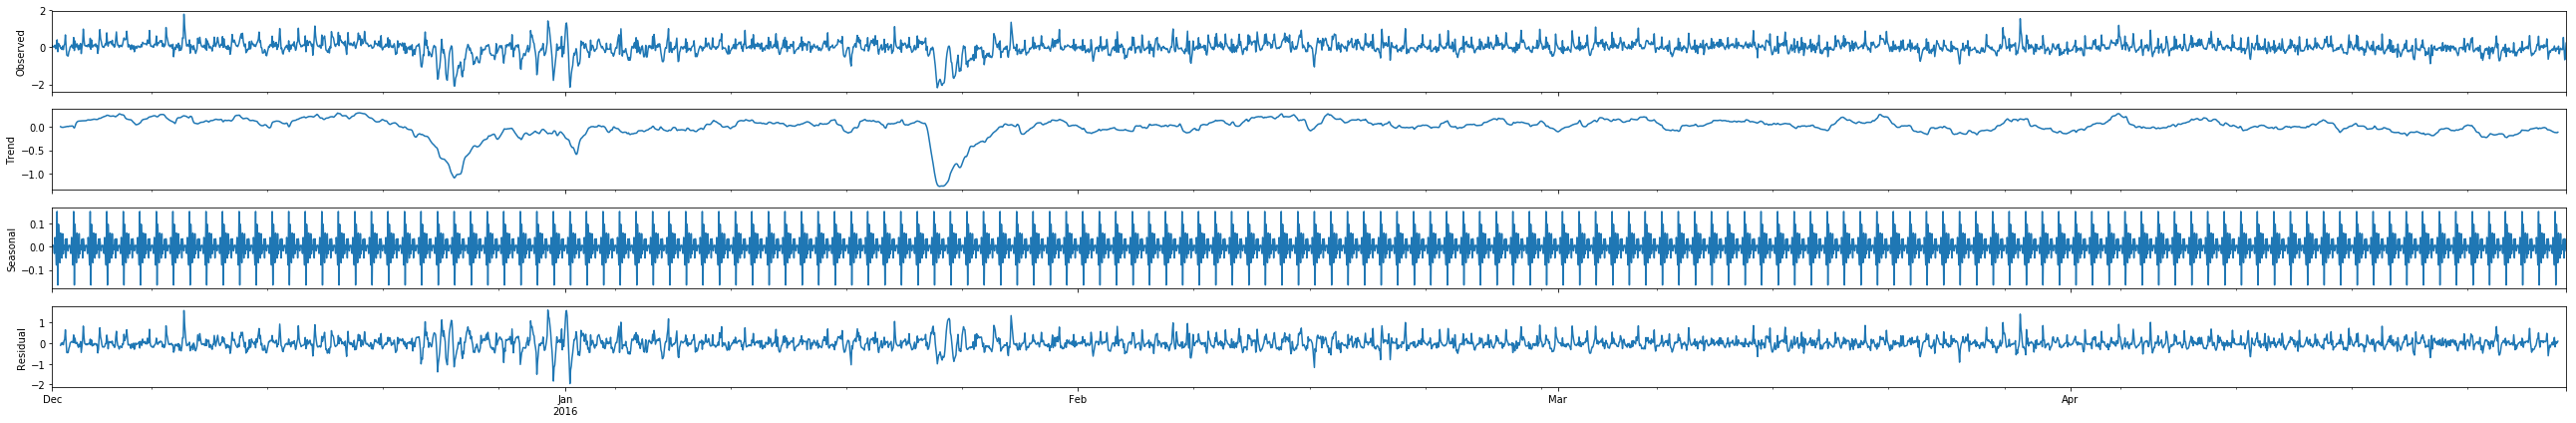

In [80]:
sm.tsa.seasonal_decompose(data_norm.c3_residuals).plot()
pass

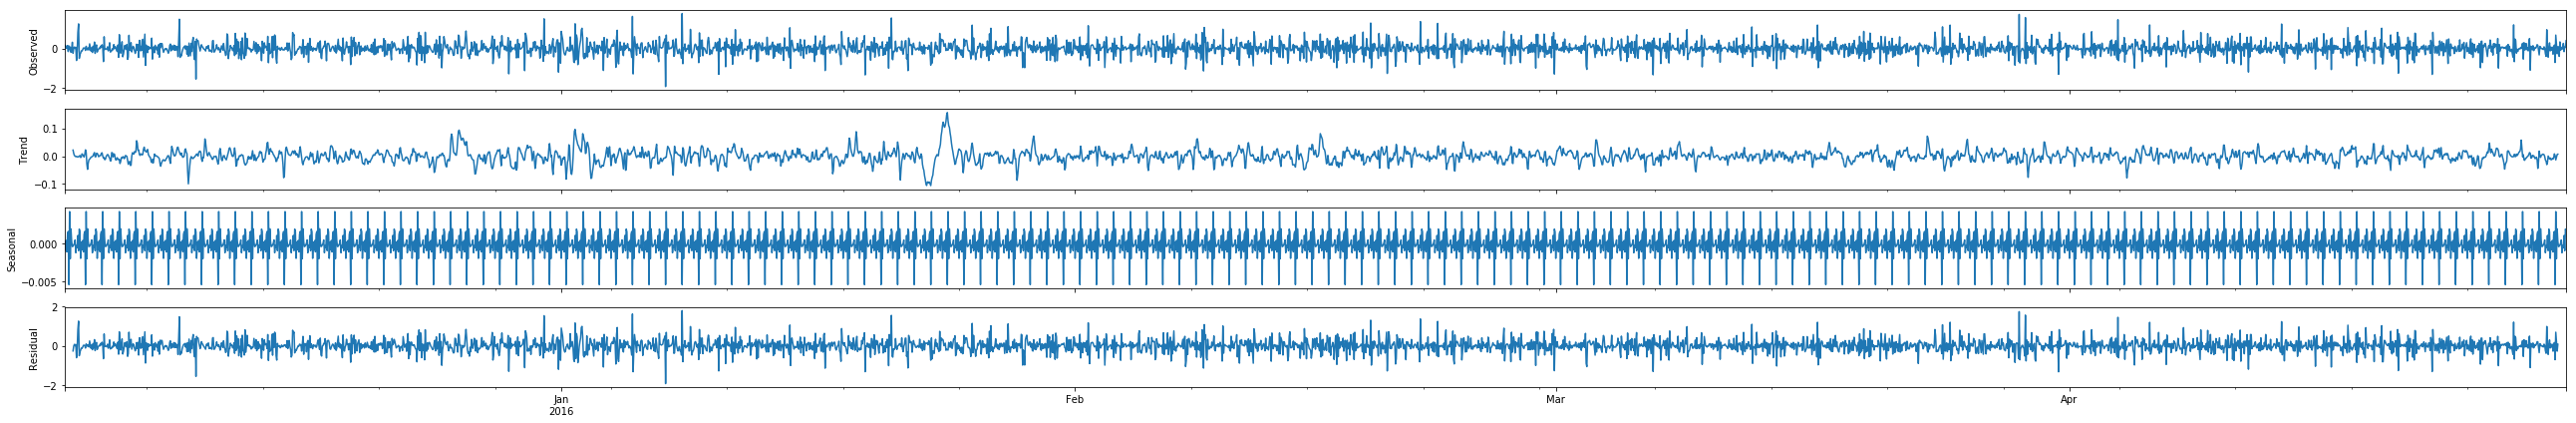

In [81]:
data_norm.c3_residuals_diff = data_norm.c3_residuals - data_norm.c3_residuals.shift(24)
data_norm.c3_residuals_diff2 = data_norm.c3_residuals_diff - data_norm.c3_residuals_diff.shift(1)
sm.tsa.seasonal_decompose(data_norm.c3_residuals_diff2[25:]).plot()
pass

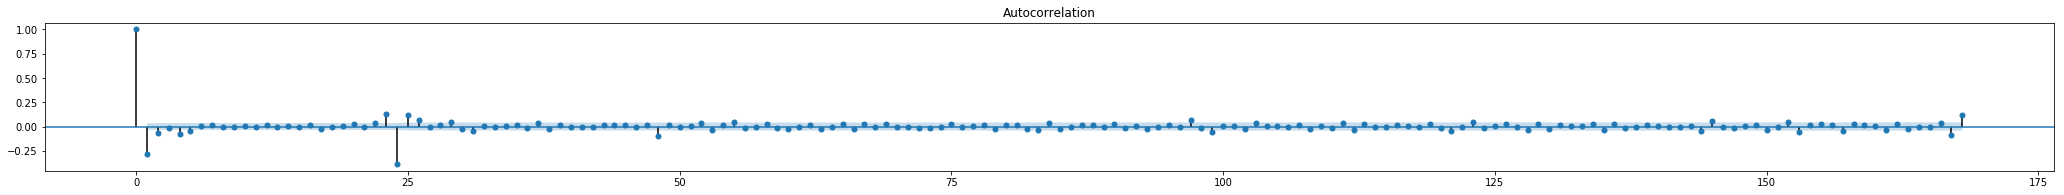

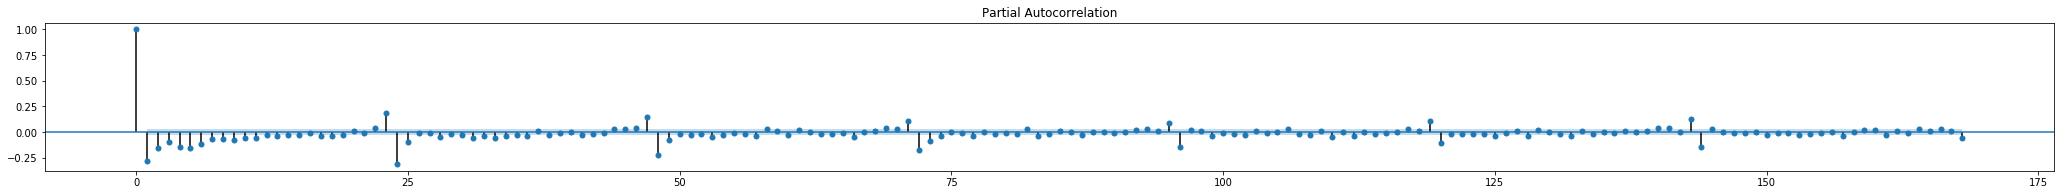

In [82]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_norm.c3_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_norm.c3_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

In [84]:
ARIMA['c3'] = {
    'Q': 1,
    'q': 1,
    'P': 2,
    'p': 5,
}

Для последнего кластера.

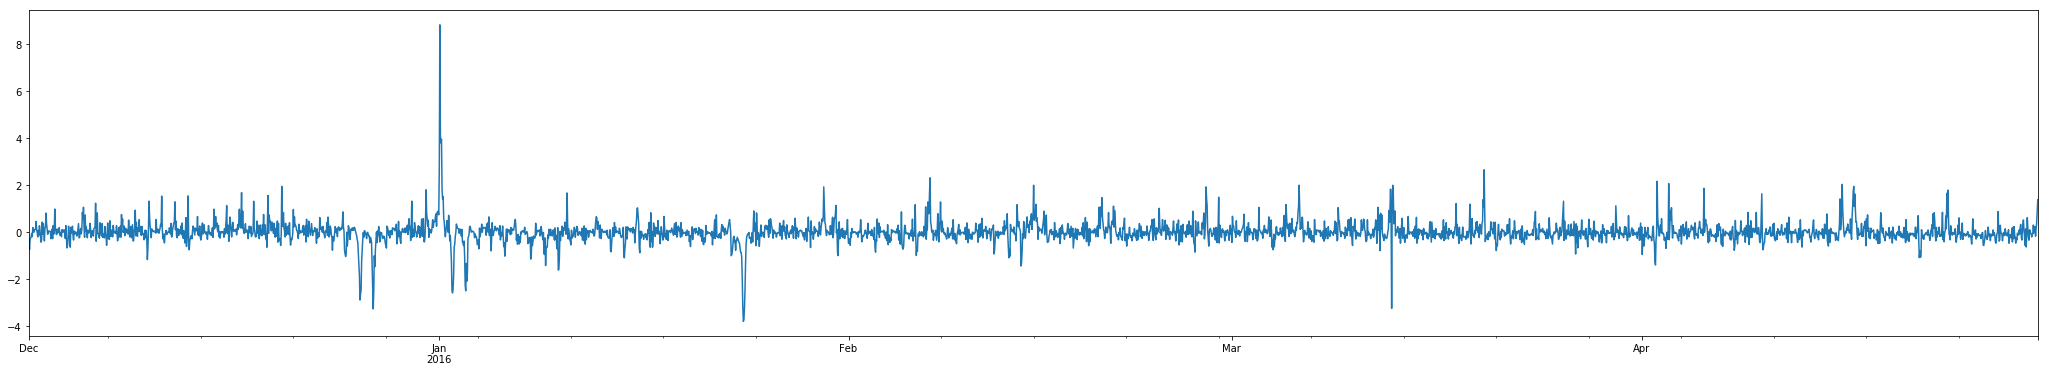

In [85]:
lrm = sklearn.linear_model.LinearRegression()
lrm.fit(ex, data_norm.c4)
data_norm.c4_residuals = data_norm.c4 - lrm.predict(ex)
data_norm.c4_residuals.plot()

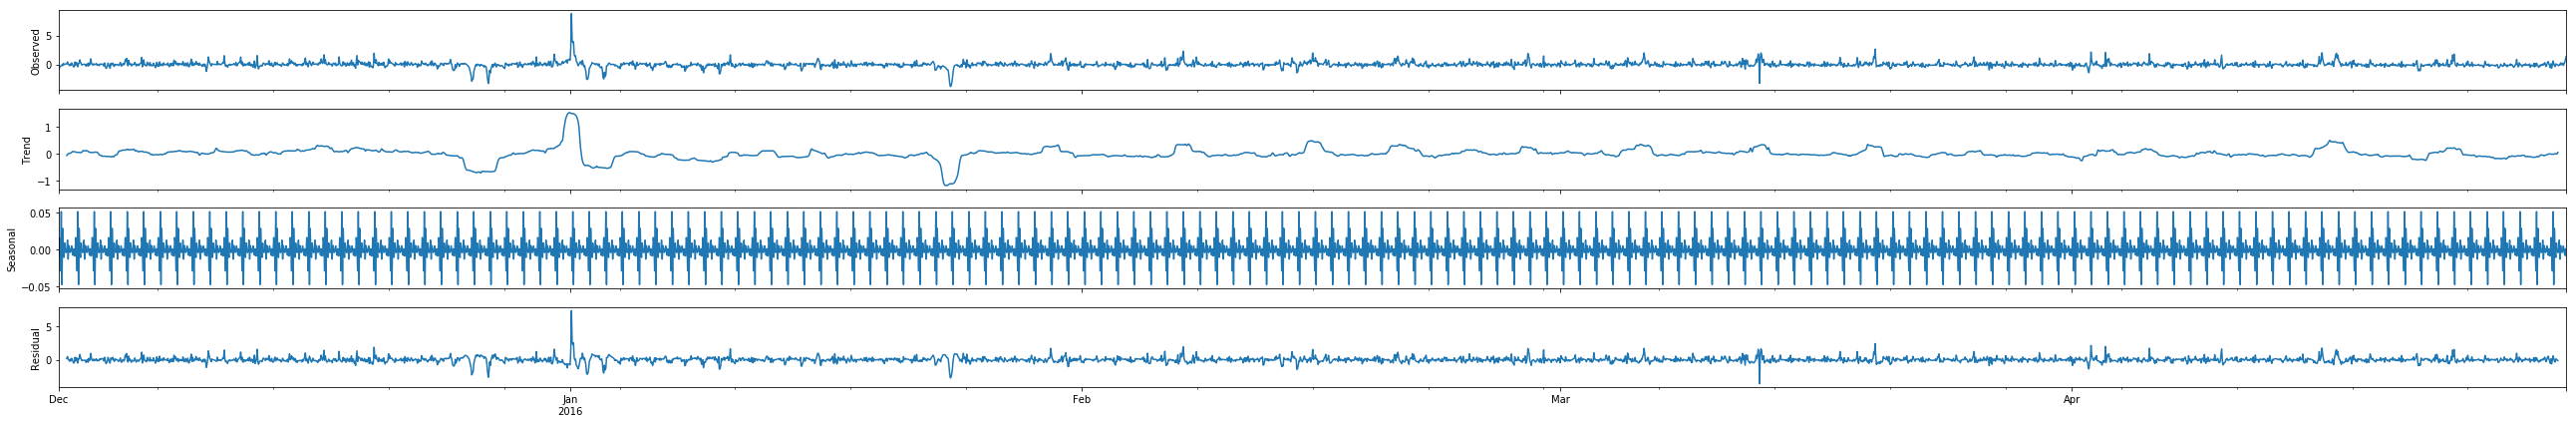

In [86]:
sm.tsa.seasonal_decompose(data_norm.c4_residuals).plot()
pass

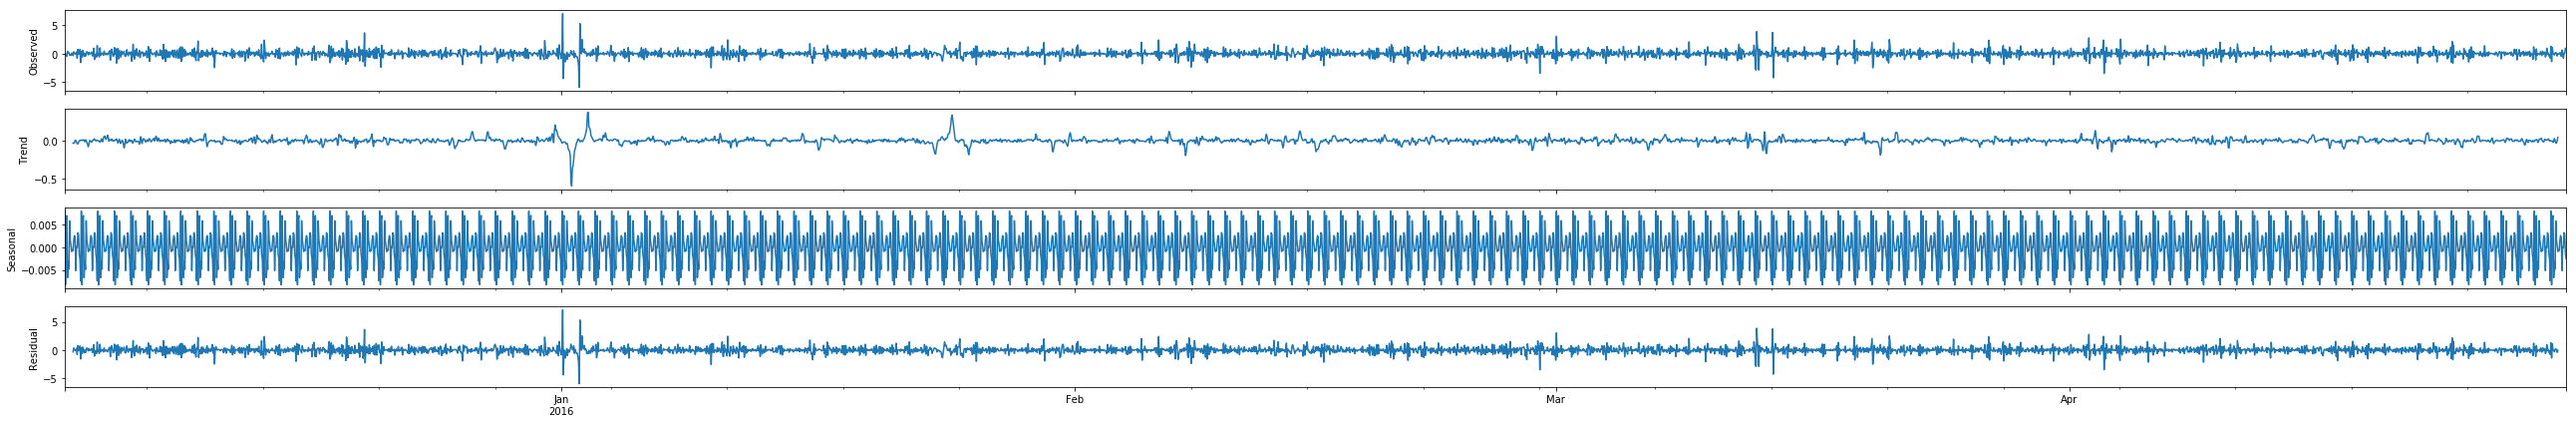

In [87]:
data_norm.c4_residuals_diff = data_norm.c4_residuals - data_norm.c4_residuals.shift(24)
data_norm.c4_residuals_diff2 = data_norm.c4_residuals_diff - data_norm.c4_residuals_diff.shift(1)
sm.tsa.seasonal_decompose(data_norm.c4_residuals_diff2[25:]).plot()
pass

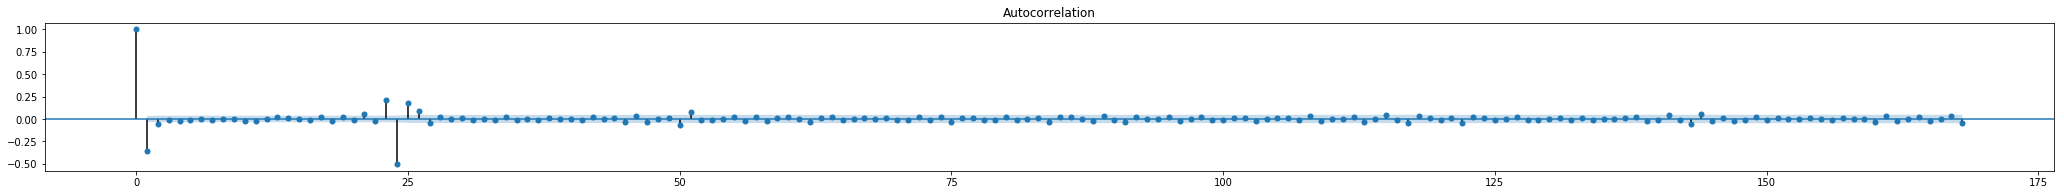

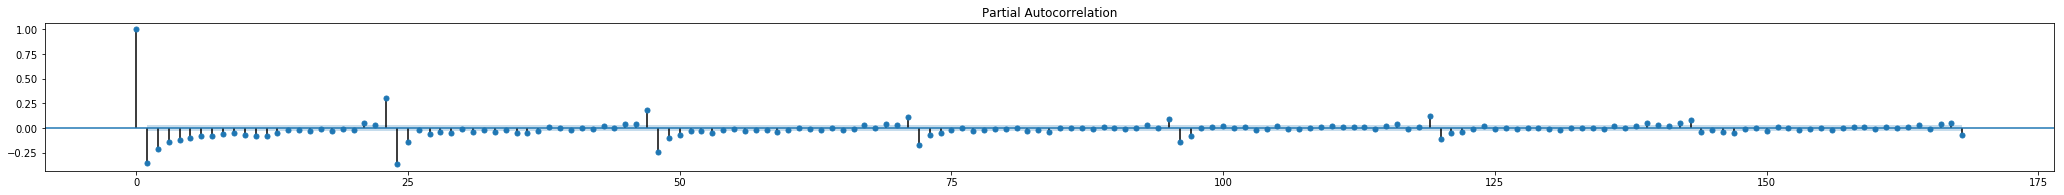

In [88]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data_norm.c4_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data_norm.c4_residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

In [89]:
ARIMA['c4'] = {
    'Q': 1,
    'q': 1,
    'P': 2,
    'p': 2,
}

In [92]:
for i in range(0, 5):
    cluster = "c" + str(i)
    print "ARIMA for cluster ", cluster
    parameters = list(itertools.product(
        range(0, ARIMA[cluster]['p']),
        range(0, ARIMA[cluster]['q']),
        range(0, ARIMA[cluster]['P']),
        range(0, ARIMA[cluster]['Q'])))
    print "Parameters: ", len(parameters)
    
    results = []
    best_aic = float("inf")
    warnings.filterwarnings("ignore")

    for param in parameters:
        print "Trying parameters:", param
        try:
            model = sm.tsa.statespace.SARIMAX(data_norm[cluster], exog=ex, order=(param[0], 1, param[1]),
                                              seasonal_order=(param[2], 1, param[3], 24)).fit(disp=-1)
        except (ValueError, LinAlgError):
            print('wrong parameters:', param)
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    warnings.filterwarnings('default')
    
    ARIMA[cluster]['results'] = results
    ARIMA[cluster]['model'] = best_model

ARIMA for cluster  c0
Parameters:  4
Trying parameters: (0, 0, 0, 0)
('wrong parameters:', (0, 0, 0, 0))
Trying parameters: (0, 0, 1, 0)


KeyboardInterrupt: 

In [94]:
%store data_norm
%store ex
%store ARIMA

Stored 'data_norm' (DataFrame)
Stored 'ex' (DataFrame)
Stored 'ARIMA' (dict)
